Lab01-1
======

###  Context
#### Clustering
   + k-means Clustering

# k-means Clustering 
### 특징
k-means Clustering은 대표적인 클러스터링 알고리즘 중 하나로, 각 클러스터에 할당된 데이터 포인트들의 평균 좌표를 이용해 중심점을 반복적으로 업데이트하며 클러스터를 형성하는 알고리즘 입니다.<br><br>
k-means Clustering 알고리즘은 3가지 단계로 이루어집니다.<br>
Step 1. 각 데이터 포인트 i 에 대해 가장 가까운
    중심점을 찾고, 그 중심점에 해당하는 클러스터를 할당합니다.
    <br>가까운 중심점을 찾을 때는, **유클리드 거리**를 사용합니다.<br>
Step 2. 할당된 클러스터를 기반으로 새로운 중심점을 계산합니다.
    중심점은 클러스터 내부 점들 좌표의 **산술 평균(mean)**
    으로 합니다.<br>
Step 3. 각 클러스터의 할당이 바뀌지 않을 때까지 반복합니다.

In [1]:
from os.path import join
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time

datapath = join('data','wine.txt')
labelpath = join('data','wine_attributes.txt')

columns = list()
with open(labelpath, 'r') as f:
    columns = f.read().split('\n')

## 1. 데이터 살펴보기
이번 장에서 우리가 사용할 데이터는 178개의 행과 14개의 열로 이루어진 와인 데이터 입니다.
<br>데이터를 살펴보기 쉽게 pandas DataFrame으로 읽습니다.

In [2]:
data = pd.read_csv(datapath, names = columns)

DataFrame.head() 함수로 처음 5개의 데이터를 살펴볼 수 있습니다.

In [3]:
data.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


와인 데이터는 3개의 클래스로 이루어진 데이터이므로 3개의 클러스터를 형성해 보도록 하겠습니다.<br>
한가지 주의할 점으로는 우리는 3개의 클래스로 분류하고자 클러스터링을 하는 것이 아닙니다.<br>
마지막에 이번 예제에서 형성한 클러스터가 잘 형성되었는지를 확인하기 위해 실제 클래스를 변수로 저장해둡니다.

In [4]:
real_label = data['Class']
del data['Class']

 ## 2. 간단한 전처리와 준비

wine 데이터는 13개의 컬럼을 가지고 있고, 하나의 데이터(행)는 13개의 차원으로 이루어진 벡터라고 볼 수 있습니다. <br>
13차원은 우리 눈으로 볼 수 있도록 표현하기 어려우므로 두개의 컬럼을 선택해 시각화할 수 있도록 해봅시다.<br>
또한, 각 변수들의 값의 범위를 min-max 정규화를 통해 조정해주겠습니다.

In [5]:
for dim in data.columns:
        data[dim] -= np.min(data[dim])
        data[dim] /= np.max(data[dim])

In [6]:
X = np.array(pd.concat([data['Ash'] ,data['Nonflavanoid phenols']],axis=1))

 ### 점과 점사이의 거리를 어떻게 측정할 수 있을까? 

 k-means clustering은 거리 기반 알고리즘이므로 여러가지 방법으로 거리를 측정할 수 있습니다.<br>
 세 가지 거리 측정 방식을 소개해 보도록 하겠습니다.<br>
 #### 1. Manhattan Distance - 각 축에 대해 수직으로만 이동하여 계산하는 거리 측정방식
 $$D(x,y) = {{\sum_{i=1}^{d}  |x_i - y_i|} } $$
 ![./Images/Manhattan.png](./Images/Manhattan.png)
 
 #### 2. Euclidean Distance - 점과 점사이의 가장 짧은 거리를 계산하는 거리 측정방식
 $$D(x,y) = {\sqrt{\sum_{i=1}^{d}  (x_i - y_i)^2} } $$
 ![./Images/Euclidean.png](./Images/Euclidean.png)
 
 #### 3. Mahalanobis Distance - 확률 분포상의 거리 측정방식
 $$D(x,y) = {\sum_{i=1}^{d} ({{x_i-y_i}\over \sigma_i })^2} $$
 ![./Images/Mahalanobis.png](./Images/Mahalanobis.png)
 

 이번 예제에서는 각 점들의 거리를 **유클리드 거리**를 사용하겠습니다.

In [7]:
def distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2)) 

In [8]:
n_clusters = 3
N = len(data)
print('클러스터의 개수는 {}개. 데이터의 개수는 {}개 입니다.'.format(n_clusters, N))

클러스터의 개수는 3개. 데이터의 개수는 178개 입니다.


 ### 클러스터의 중심점 및 할당 클러스터 라벨 초기화
각 클러스터의 첫 중심점은 3(k)개의 데이터를 임의로 선택하여 사용합니다.<br>random.sample(data, k) 함수는 data에서 k개 만큼 비복원 추출 합니다.

In [9]:
initial_centroid_indices = random.sample(range(0, N), n_clusters)
centroids = X[initial_centroid_indices]

그리고 각 점들이 할당될 labels 행렬을 초기화하고 알고리즘을 시작합니다.

In [10]:
labels = np.zeros(N)

## 3. Scratch로 클러스터링 해보기

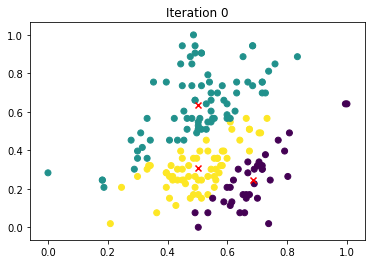

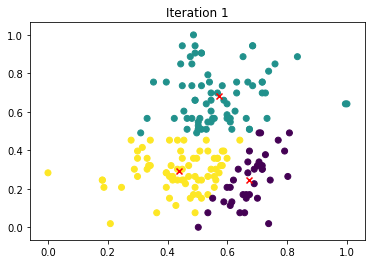

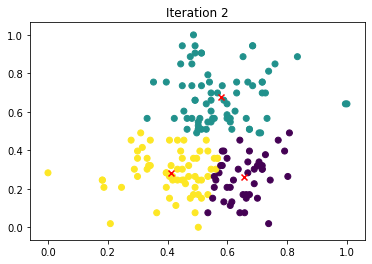

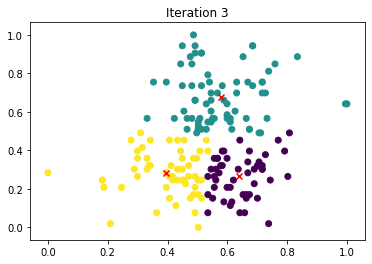

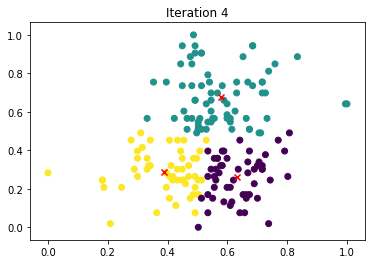

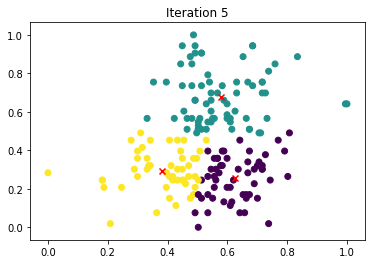

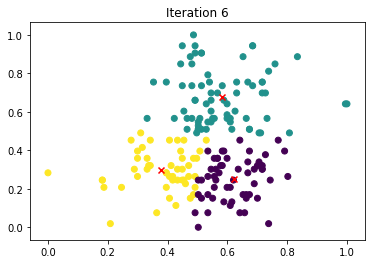

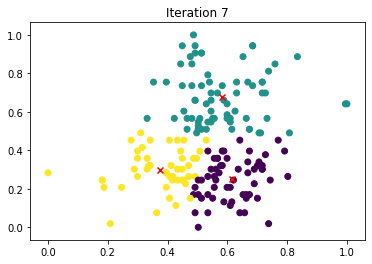

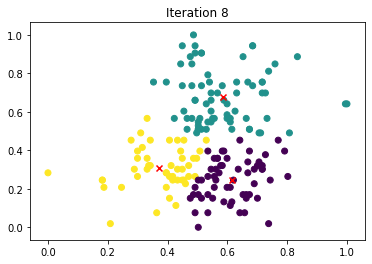

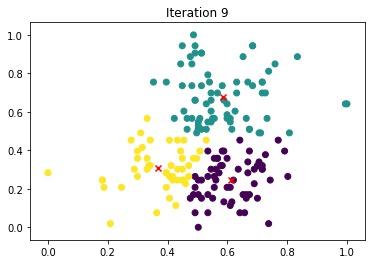

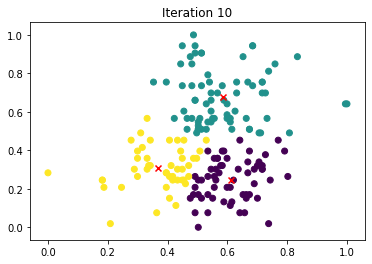

In [11]:
iteration = 0

while True:
    plt.figure()
    #is_changed 변수에 각 클러스터의 할당이 변했는지의 유무를 저장합니다.
    is_changed = False
    
    #i번째 데이터에 대해 모든 클러스터와의 거리를 계산합니다.
    for i in range(N):
        distances = []
        #k번째 클러스터의 중심점과의 거리를 계산해 distances 리스트에 저장합니다.
        #distances 리스트의 인덱스가 각 클러스터의 번호가 됩니다.
        for k in range(n_clusters):
            k_dist = distance(X[i], centroids[k])
            distances.append(k_dist)
            
        #np.argmin(X) 함수는 X(리스트)의 값들 중 가장 작은 값의 인덱스를 반환합니다.
        #i번째 데이터의 Label 값이 현재 가장 가까운 거리의 인덱스(클러스터 번호)와 다르다면, 
        #새로운 클러스터에 할당된 것이므로 변경되었음을 is_changed 변수에 저장합니다.
        if labels[i] != np.argmin(distances):
            is_changed = True

        #i번째 데이터에 새로운 클러스터를 할당합니다.
        labels[i] = np.argmin(distances)
        
    #모든 클러스터의 중심점을 갱신합니다.
    for k in range(n_clusters):
        #numpy의 ndarray는 인덱스에 논리 연산을 넣어 True 값을 갖는 데이터를 가져올 수 있습니다.
        #labels 값(클러스터 번호)이 k와 같은 데이터를 가져옵니다. 
        x = X[labels == k][:,0] #x좌표
        y = X[labels == k][:,1] #y좌표
        x = np.mean(x) #x좌표의 산술평균
        y = np.mean(y) #y좌표의 산술평균
        
        #중심점 갱신
        centroids[k] = [x,y]
        
    plt.scatter(X[:,0], X[:,1], c=labels)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', c = 'red')
    plt.title('Iteration {}'.format(iteration))
    plt.show()
    
    #클러스터의 할당이 변경되지 않았다면, 알고리즘을 멈춥니다.
    if not is_changed :
        break
    iteration += 1
        

## 4. Scratch 클러스터링 결과 살펴보기

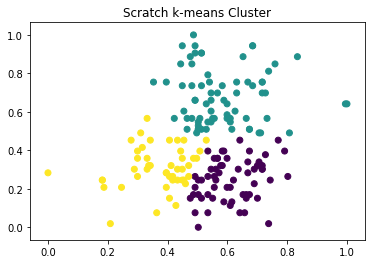

In [12]:
plt.scatter(X[:,0], X[:,1], c=labels)
plt.title('Scratch k-means Cluster')
plt.show()

## 5. Sklearn으로 클러스터링 해보기
Sklearn의 KMeans 모델을 만들어 냅니다. 생성하고자 하는 클러스터의 수는 3(num_clusters)개로 지정하여 생성합니다. <br>init 매개변수는 중심점 초기화 방법을 나타내며, Scratch 클러스터링과 동일하게 임의로 선택하고자 'random'으로 설정합니다.

In [13]:
kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=0)

fit() 함수를 사용해 k-means 모델에 데이터를 넣어 클러스터를 생성합니다.

In [14]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

predict() 함수를 사용해 data의 클러스터를 결정합니다.

In [15]:
labels = kmeans.predict(X)

## 6. Sklearn 클러스터링 결과 
Sklearn 클러스터링으로 형성된 클러스터를 기준으로 시각화와 함께 각 클러스터 별 변수의 평균을 살펴보겠습니다.<br>
numpy는 'ndarray == 값'을 통해 특정한 값을 가진 인덱스의 위치를 논리 값으로 반환시킬 수 있습니다.<br>
그렇게 반환한 논리 값을 인덱스로 사용해 특정한 값들을 추출할 수 있습니다.

In [16]:
#labels numpy 배열로부터 특정한 클러스터에 할당된 점의 인덱스를 뽑아 점을 선택합니다.
clusters = list()
for i in range(n_clusters):
    clusters.append(X[labels == i])

데이터의 첫 번째 변수는 'Ash', 두 번째 변수는 'Nonflavanoid phenols' 입니다. <br>
클러스터별 2가지 변수의 평균을 계산합니다. 이번에도 동일하게 numpy.mean() 함수를 사용합니다.

In [17]:
for i, x_c in enumerate(clusters):
    print('{}번 클러스터의 \'Ash\' 변수 평균 : {:.2f} \'Nonflavanoid phenols\' 변수의 평균 : {:.2f}'.format(
                                                                    i,
                                                                    np.mean(x_c[:,0]), 
                                                                    np.mean(x_c[:,1])))

0번 클러스터의 'Ash' 변수 평균 : 0.61 'Nonflavanoid phenols' 변수의 평균 : 0.25
1번 클러스터의 'Ash' 변수 평균 : 0.37 'Nonflavanoid phenols' 변수의 평균 : 0.31
2번 클러스터의 'Ash' 변수 평균 : 0.58 'Nonflavanoid phenols' 변수의 평균 : 0.68


각 클러스터에 대한 두 변수들의 평균을 통해 명확히 다른 값들을 가지고 있음을 확인하였습니다.

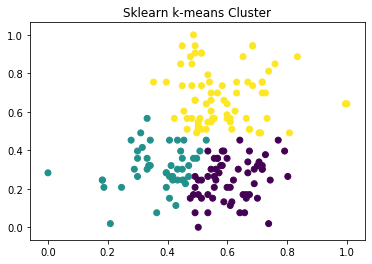

In [18]:
plt.scatter(X[:,0], X[:,1], c=labels)
plt.title('Sklearn k-means Cluster')
plt.show()

## 7. Discussion
k-means 알고리즘을 통해 생성한 클러스터들이 정말로 잘 만들어진 클러스터 일까요? 클러스터링은 비지도학습 기법이라 실제로는 레이블을 가지고 클러스터링을 하지 않습니다.<br>
그렇지만 지금은 우리가 실제 레이블을 알고 있으니 비교해보도록 합시다. 여기에서 **한가지 주의할 점은 클러스터링의 목적은 특정 레이블에 대한 분류가 아닙니다.**<br> 
**이것으로 클러스터링 알고리즘으로 만든 클러스터가 실제 우리가 원하는대로 비슷한 데이터들끼리 클러스터링 될 수도 있고 그렇지 않을 수도 있다는 것을 알 수 있습니다.**<br>
실제 레이블과의 비교로 클러스터링 알고리즘의 성능을 평가할 수 없으므로 클러스터링 알고리즘의 성능 평가는 잠시 미뤄두도록 하겠습니다.

Text(0.5, 1.0, 'Real Label')

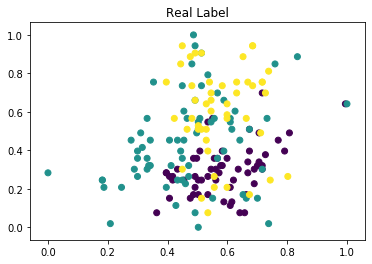

In [19]:
plt.scatter(X[:,0], X[:,1], c=real_label)
plt.title('Real Label')